In [1]:
from pickle import load
from numpy import array
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical 
from keras.utils.vis_utils import plot_model 
from keras.models import Sequential 
from keras.layers import LSTM, Dense, Embedding, RepeatVector, TimeDistributed 
from keras.callbacks import ModelCheckpoint

2023-06-17 08:55:50.895535: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-17 08:55:50.995110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-06-17 08:55:50.995130: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-06-17 08:55:51.467941: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-1

In [2]:
def load_clean_sentences(filename):
    return load(open(filename, 'rb'))

In [3]:
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer 

In [4]:
def max_length(lines):
    return max(len(line.split()) for line in lines)

In [5]:
lines = ['The National Basketball Association (NBA) is a professional basketball league in North America composed of 30 teams', 'It is one of the major professional sports leagues in the United States and Canada and is considered the premier professional basketball league in the world.']
print(lines[0].split())
print(max_length(lines))

['The', 'National', 'Basketball', 'Association', '(NBA)', 'is', 'a', 'professional', 'basketball', 'league', 'in', 'North', 'America', 'composed', 'of', '30', 'teams']
26


In [6]:
def encode_sequences(tokenizer, length, lines):
    X = tokenizer.texts_to_sequences(lines)
    X = pad_sequences(X, maxlen=length, padding='post')
    return X

In [7]:
def encode_output(sequences, vocab_size):
    ylist = list()
    for sequence in sequences:
        encoded = to_categorical(sequence, num_classes=vocab_size)
        ylist.append(encoded)
    y = array(ylist)
    y = y.reshape(sequences.shape[0], sequences.shape[1], vocab_size)
    return y

In [8]:
def define_model(src_vocab, tar_vocab, src_timesteps, tar_timesteps, n_units):
    model = Sequential()
    model.add(Embedding(src_vocab, n_units, input_length=src_timesteps, mask_zero=True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(tar_timesteps))
    model.add(LSTM(n_units, return_sequences=True))
    model.add(TimeDistributed(Dense(tar_vocab, activation='softmax')))
    return model 

In [9]:
dataset = load_clean_sentences('../Data_Cleaning/english-german-both.pkl')
train = load_clean_sentences('../Data_Cleaning/english-german-train.pkl')
test = load_clean_sentences('../Data_Cleaning/english-german-test.pkl')

In [10]:
eng_tokenizer = create_tokenizer(dataset[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1
eng_length = max_length(dataset[:, 0])
print(eng_vocab_size, eng_length)
#
ger_tokenizer = create_tokenizer(dataset[:, 1])
ger_vocab_size = len(ger_tokenizer.word_index) + 1
ger_length = max_length(dataset[:, 1])
print(ger_vocab_size, ger_length)

2166 5
3539 8


In [11]:
trainX = encode_sequences(ger_tokenizer, ger_length, train[:,1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:,0])
trainY = encode_output(trainY, eng_vocab_size)
#
testX = encode_sequences(ger_tokenizer, ger_length, test[:,1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:,0])
testY = encode_output(testY, eng_vocab_size)

2023-06-17 08:55:52.684753: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-06-17 08:55:52.684775: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-17 08:55:52.684791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joseph-VirtualBox): /proc/driver/nvidia/version does not exist
2023-06-17 08:55:52.684992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 8, 256)            905984    
                                                                 
 lstm (LSTM)                 (None, 256)               525312    
                                                                 
 repeat_vector (RepeatVector  (None, 5, 256)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 5, 256)            525312    
                                                                 
 time_distributed (TimeDistr  (None, 5, 2166)          556662    
 ibuted)                                                         
                                                                 
Total params: 2,513,270
Trainable params: 2,513,270
Non-

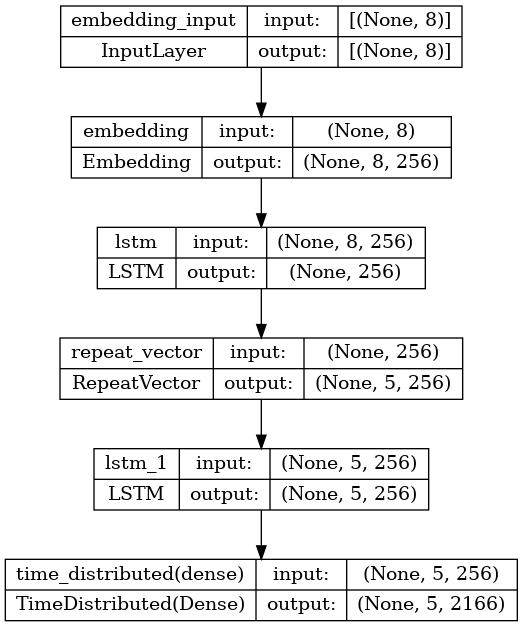

In [12]:
model = define_model(ger_vocab_size, eng_vocab_size, ger_length, eng_length, n_units=256)
model.compile(optimizer='adam', loss='categorical_crossentropy')
print(model.summary())
plot_model(model, to_file='model.png', show_shapes=True)

In [42]:
filename = 'model.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbos=1, save_best_only=True, mode='min')
model.fit(trainX, trainY, epochs=30, batch_size=64, validation_data=(testX, testY), callbacks=[checkpoint], verbose=2)

2023-06-17 08:03:46.913360: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 389880000 exceeds 10% of free system memory.


Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing t